In [1]:
import pickle
import numpy as np

In [4]:
with open('single_train_set', 'rb') as f:
    train_data = pickle.load(f)

In [5]:
with open('single_test_set', 'rb') as f:
    test_data = pickle.load(f)

In [142]:
test_data[0 : 5]

[(['John',
   'travelled',
   'to',
   'the',
   'hallway',
   '.',
   'Mary',
   'journeyed',
   'to',
   'the',
   'bathroom',
   '.'],
  ['Where', 'is', 'John', '?'],
  'hallway'),
 (['Daniel',
   'went',
   'back',
   'to',
   'the',
   'bathroom',
   '.',
   'John',
   'moved',
   'to',
   'the',
   'bedroom',
   '.'],
  ['Where', 'is', 'Mary', '?'],
  'bathroom'),
 (['John',
   'went',
   'to',
   'the',
   'hallway',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'kitchen',
   '.'],
  ['Where', 'is', 'Sandra', '?'],
  'kitchen'),
 (['Sandra',
   'travelled',
   'to',
   'the',
   'hallway',
   '.',
   'John',
   'went',
   'to',
   'the',
   'garden',
   '.'],
  ['Where', 'is', 'Sandra', '?'],
  'hallway'),
 (['Sandra',
   'went',
   'back',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'moved',
   'to',
   'the',
   'kitchen',
   '.'],
  ['Where', 'is', 'Sandra', '?'],
  'kitchen')]

In [7]:
len(train_data), len(test_data)

(10000, 1000)

In [8]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . John went to the hallway .'

In [9]:
' '.join(train_data[0][1])

'Where is Mary ?'

In [10]:
train_data[0][2]

'bathroom'

In [11]:
all_data = test_data + train_data

In [12]:
len(all_data)

11000

In [13]:
vocab = set()
count = 0
for story, question, answer in train_data:
    if ' ' in story or ' ' in question  or ' ' in answer:
        print(story, question, answer)
        count += 1
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
#     vocab = vocab.union(set([answer]))
len(vocab)
print(count)

0


In [14]:
# vocab = vocab.union(set(['yes', 'no']))
vocab

{'.',
 '?',
 'Daniel',
 'John',
 'Mary',
 'Sandra',
 'Where',
 'back',
 'bathroom',
 'bedroom',
 'garden',
 'hallway',
 'is',
 'journeyed',
 'kitchen',
 'moved',
 'office',
 'the',
 'to',
 'travelled',
 'went'}

In [15]:
vocab_len = len(vocab) + 1  #one extra for keras pad-sequences placeholder

In [16]:
vocab_len

22

In [17]:
# LONGEST STORY
all_story_lengths = [len(data[0]) for data in all_data]

# LONGEST QUESTION
all_ques_lengths = [len(data[1]) for data in all_data]

In [18]:
max_story_len = max(all_story_lengths)

In [19]:
max_story_len

14

In [20]:
max_ques_len = max(all_ques_lengths)

In [21]:
max_ques_len

4

In [22]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [23]:
tokenizer = Tokenizer(filters=[])  # default fiter is not required

In [24]:
tokenizer.fit_on_texts(vocab)

In [25]:
tokenizer.texts_to_sequences(all_data[0])

[[3, 18, 14, 13, 21, 15, 8, 19, 14, 13, 1, 15], [16, 12, 3, 10], [21]]

In [26]:
tokenizer.word_index

{'.': 15,
 '?': 10,
 'back': 2,
 'bathroom': 1,
 'bedroom': 5,
 'daniel': 20,
 'garden': 11,
 'hallway': 21,
 'is': 12,
 'john': 3,
 'journeyed': 19,
 'kitchen': 6,
 'mary': 8,
 'moved': 9,
 'office': 7,
 'sandra': 4,
 'the': 13,
 'to': 14,
 'travelled': 18,
 'went': 17,
 'where': 16}

In [27]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_ques_len=max_ques_len):
    X = []
    Xq = []
    Y = []
    
    for story, question, answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in question]
        y = np.zeros(len(word_index) + 1)
        
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_ques_len), np.array(Y))

In [28]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [29]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [30]:
inputs_train

array([[ 0,  0,  8, ..., 13, 21, 15],
       [ 0, 20, 17, ..., 13, 11, 15],
       [ 0,  0,  3, ..., 13,  1, 15],
       ...,
       [ 4, 17,  2, ..., 13,  6, 15],
       [ 0, 20, 17, ..., 13,  1, 15],
       [ 0,  3, 17, ..., 13,  5, 15]], dtype=int32)

In [31]:
sum(answers_test), len(answers_test)

(array([  0., 149.,   0.,   0.,   0., 171., 157., 182.,   0.,   0.,   0.,
        187.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 154.]),
 1000)

In [32]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Dense, LSTM, Input, Activation, Permute, Dropout, add, dot, concatenate

In [33]:
# PLCEHOLDER shape=(max_story_len, batch_size)
input_sequence = Input((max_story_len, ))
question = Input((max_ques_len, ))

In [34]:
# SAME AS vocab_len
vocab_size = len(vocab) + 1

In [35]:
vocab_size

22

In [36]:
# INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

# OUTPUT
# (samples, max_len_story, embedding_dim)

In [37]:
# INPUT ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_ques_len))
input_encoder_m.add(Dropout(0.3))

# OUTPUT
# (samples, max_len_story, max_ques_len)

In [38]:
# QUESTION ENCODER
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64))
question_encoder.add(Dropout(0.3))

# OUTPUT
# (samples, max_len_story, embedding_dim)

In [39]:
# ENCODED <--- ENCODER(INPUT)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [40]:
input_encoded_m, question_encoded, input_encoded_c

(<tf.Tensor 'sequential_1/dropout_2/cond/Identity:0' shape=(None, 14, 64) dtype=float32>,
 <tf.Tensor 'sequential_3/dropout_3/cond/Identity:0' shape=(None, 4, 64) dtype=float32>,
 <tf.Tensor 'sequential_2/embedding_2/embedding_lookup/Identity_1:0' shape=(None, 14, 4) dtype=float32>)

In [41]:
# calculating match between m (Embedding A) and q (Embedding B)

match = dot([input_encoded_m, question_encoded], axes=(2,2))
match = Activation('softmax')(match)

In [42]:
match

<tf.Tensor 'activation_1/truediv:0' shape=(None, 14, 4) dtype=float32>

In [43]:
response = add([input_encoded_c, match])
response = Permute((2, 1))(response)

In [44]:
response

<tf.Tensor 'permute_1/transpose:0' shape=(None, 4, 14) dtype=float32>

In [45]:
answer = concatenate([response, question_encoded])

In [46]:
answer

<tf.Tensor 'concatenate_1/concat:0' shape=(None, 4, 78) dtype=float32>

In [47]:
answer = LSTM(32)(answer)

In [48]:
answer = Dropout(0.5)(answer)

In [49]:
answer = Dense(vocab_size)(answer) # (samples, vocab_size) YES/NO

In [50]:
answer

<tf.Tensor 'dense_1/BiasAdd:0' shape=(None, 22) dtype=float32>

In [51]:
answer = Activation('softmax')(answer)

In [52]:
model = Model([input_sequence, question], answer)

In [53]:
model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=['accuracy'])

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 14)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             1408        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_3 (Sequential)       multiple             1408        input_2[0][0]                    
____________________________________________________________________________________________

In [55]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=150, validation_data=([inputs_test, queries_test], answers_test))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 10000 samples, validate on 1000 samples
Epoch 1/150
10000/10000 [==============================] - 2s 207us/step - loss: 2.0019 - accuracy: 0.1776 - val_loss: 1.7697 - val_accuracy: 0.2520
Epoch 2/150
10000/10000 [==============================] - 1s 136us/step - loss: 1.7269 - accuracy: 0.2309 - val_loss: 1.6643 - val_accuracy: 0.2540
Epoch 3/150
10000/10000 [==============================] - 1s 137us/step - loss: 1.6533 - accuracy: 0.2933 - val_loss: 1.6027 - val_accuracy: 0.3560
Epoch 4/150
10000/10000 [==============================] - 1s 135us/step - loss: 1.5603 - accuracy: 0.3853 - val_loss: 1.5106 - val_accuracy: 0.3990
Epoch 5/150
10000/10000 [==============================] - 1s 136us/step - loss: 1.5225 - accuracy: 0.4069 - val_loss: 1.4946 - val_accuracy: 0.4000
Epoch 6/150
10000/10000 [==============================] - 1s 138us/step - loss: 1.5081 - accuracy: 0.4114 - val_loss: 1.5095 - val_accuracy: 0.4160
Epoch 7/150
10000/10000 [==============================] 

In [56]:
model.save('my_new_single_trained_model_1.h5')

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])
{'val_loss': [1.7696758060455322, 1.6643094215393066, 1.6026945781707764, 1.5105930709838866, 1.4945538997650147, 1.5094666805267334, 1.4877574920654297, 1.4735319538116456, 1.4631745767593385, 1.4424916648864745, 1.3998296527862548, 1.3734779539108277, 1.3574451189041137, 1.345405014038086, 1.3319494457244874, 1.3225426998138428, 1.3196471815109252, 1.3111588115692139, 1.30682315826416, 1.2950904531478882, 1.2909039707183838, 1.2821711339950561, 1.2855118217468262, 1.2824398803710937, 1.2964886026382447, 1.2783723087310792, 1.2611988992691041, 1.2505497131347656, 1.204425012588501, 1.1155901050567627, 0.9732022647857665, 0.875159215927124, 0.811066722869873, 0.7531215629577637, 0.6811474895477295, 0.6172580318450928, 0.5731070671081543, 0.5467709472179413, 0.5359936792850495, 0.5317655823230744, 0.5298782169818879, 0.527853120803833, 0.5278377587795258, 0.5255903117656707, 0.5247368679046631, 0.5249459700584411, 0.52499577307

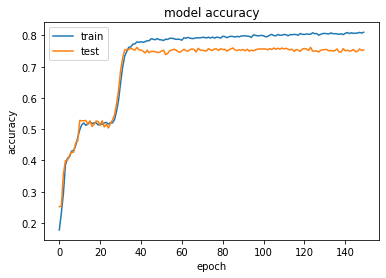

In [60]:
import matplotlib.pyplot as plt

print(history.history.keys())
#Summarize history for accuracy
print(history.history)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('my_new_trained_model.h5')

In [61]:
pred_results = model.predict(([inputs_test, queries_test]))

In [62]:
val_max = np.argmax(pred_results[0])

In [63]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [64]:
k

'hallway'

In [65]:
pred_results[0][val_max]

1.0

In [66]:
# NOW WE'LL TEST THE MODEL WITH OUR VERY OWN STORY
#NOTE: As the model has been trained on the vocab of just 38 words, we'll have to create the story with the words in vocab

vocab

{'.',
 '?',
 'Daniel',
 'John',
 'Mary',
 'Sandra',
 'Where',
 'back',
 'bathroom',
 'bedroom',
 'garden',
 'hallway',
 'is',
 'journeyed',
 'kitchen',
 'moved',
 'office',
 'the',
 'to',
 'travelled',
 'went'}

In [99]:
# EXAMPLE 1
my_story = "John travelled to the hallway . Mary journeyed to the bedroom . John moved to the office ."
my_ques = "Where is John ?"

In [100]:
mydata = [(my_story.split(), my_ques.split(), 'office')]

In [101]:
mydata

[(['John',
   'travelled',
   'to',
   'the',
   'hallway',
   '.',
   'Mary',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.',
   'John',
   'moved',
   'to',
   'the',
   'office',
   '.'],
  ['Where', 'is', 'John', '?'],
  'office')]

In [102]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [103]:
pred_ans = model.predict(([my_story, my_ques]))

In [104]:
val_max = np.argmax(pred_ans)

In [105]:
#Generate prediction from model
val_max = np.argmax(pred_ans[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_ans[0][val_max])

Predicted answer is:  office
Probability of certainty was:  0.9999999


In [106]:
pred_ans.argsort()

array([[ 4,  0,  8, 17, 12, 18, 14,  3, 19, 16,  2,  9, 10, 15, 13, 20,
        21,  6,  1, 11,  5,  7]])

In [107]:
for val_max in pred_ans.argsort()[0][-5:]:
    for key, val in tokenizer.word_index.items():
        if val == val_max:
            k = key
    print("Predicted answer is: ", k)
    print("Probability of certainty was: ", pred_ans[0][val_max])

Predicted answer is:  kitchen
Probability of certainty was:  1.7761385e-08
Predicted answer is:  bathroom
Probability of certainty was:  4.421059e-08
Predicted answer is:  garden
Probability of certainty was:  4.4512998e-08
Predicted answer is:  bedroom
Probability of certainty was:  6.3033625e-08
Predicted answer is:  office
Probability of certainty was:  0.9999999


In [108]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [98]:
model.save('/content/gdrive/My Drive/trained_model.h5')

In [109]:
vocab

{'.',
 '?',
 'Daniel',
 'John',
 'Mary',
 'Sandra',
 'Where',
 'back',
 'bathroom',
 'bedroom',
 'garden',
 'hallway',
 'is',
 'journeyed',
 'kitchen',
 'moved',
 'office',
 'the',
 'to',
 'travelled',
 'went'}

In [125]:
# EXAMPLE 2
my_story = "Daniel journeyed to the Kitchen . John went to the bedroom . John travelled to the office . Daniel went to the garden . Sandra moved back to the Kitchen ."
my_ques = "Where is Daniel ?"

In [127]:
mydata = [(my_story.split(), my_ques.split(), 'garden')]

In [128]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [129]:
pred_ans = model.predict(([my_story, my_ques]))

In [130]:
val_max = np.argmax(pred_ans)

In [131]:
#Generate prediction from model
val_max = np.argmax(pred_ans[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_ans[0][val_max])

Predicted answer is:  garden
Probability of certainty was:  0.9999995


In [133]:
for val_max in pred_ans.argsort()[0][-5:]:
    for key, val in tokenizer.word_index.items():
        if val == val_max:
            k = key
    print("Predicted answer is: ", k)
    print("Probability of certainty was: ", pred_ans[0][val_max])

Predicted answer is:  bathroom
Probability of certainty was:  2.0406397e-09
Predicted answer is:  office
Probability of certainty was:  1.0415498e-08
Predicted answer is:  hallway
Probability of certainty was:  9.974871e-08
Predicted answer is:  kitchen
Probability of certainty was:  3.6766e-07
Predicted answer is:  garden
Probability of certainty was:  0.9999995


In [124]:
# Model got confused here.

In [134]:
# EXAMPLE 3
my_story = "Daniel journeyed to the Kitchen . John went to the bedroom . John travelled to the office . Daniel went to the garden . Sandra moved back to the Kitchen ."
my_ques = "Where is John ?"

In [135]:
mydata = [(my_story.split(), my_ques.split(), 'garden')]

In [136]:
mydata

[(['Daniel',
   'journeyed',
   'to',
   'the',
   'Kitchen',
   '.',
   'John',
   'went',
   'to',
   'the',
   'bedroom',
   '.',
   'John',
   'travelled',
   'to',
   'the',
   'office',
   '.',
   'Daniel',
   'went',
   'to',
   'the',
   'garden',
   '.',
   'Sandra',
   'moved',
   'back',
   'to',
   'the',
   'Kitchen',
   '.'],
  ['Where', 'is', 'John', '?'],
  'garden')]

In [137]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [138]:
pred_ans = model.predict(([my_story, my_ques]))

In [139]:
val_max = np.argmax(pred_ans)

In [140]:
#Generate prediction from model
val_max = np.argmax(pred_ans[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_ans[0][val_max])

Predicted answer is:  bathroom
Probability of certainty was:  0.27967918


In [141]:
for val_max in pred_ans.argsort()[0][-5:]:
    for key, val in tokenizer.word_index.items():
        if val == val_max:
            k = key
    print("Predicted answer is: ", k)
    print("Probability of certainty was: ", pred_ans[0][val_max])

Predicted answer is:  kitchen
Probability of certainty was:  0.078002304
Predicted answer is:  office
Probability of certainty was:  0.108335465
Predicted answer is:  hallway
Probability of certainty was:  0.19714738
Predicted answer is:  garden
Probability of certainty was:  0.27417806
Predicted answer is:  bathroom
Probability of certainty was:  0.27967918
